In [1]:
import os
from PIL import Image

image = Image.open('sample.jpg')

# Get the dimensions of the image
width, height = image.size

crop_width = 700
crop_height = 900

# Calculate the coordinates for cropping
left = (width - crop_width) // 2
top = (height - crop_height) // 2
right = left + crop_width
bottom = top + crop_height

# Crop the image
cropped_image = image.crop((left, top, right, bottom))

cropped_image.save('crop.jpg')

# Close the image
image.close()

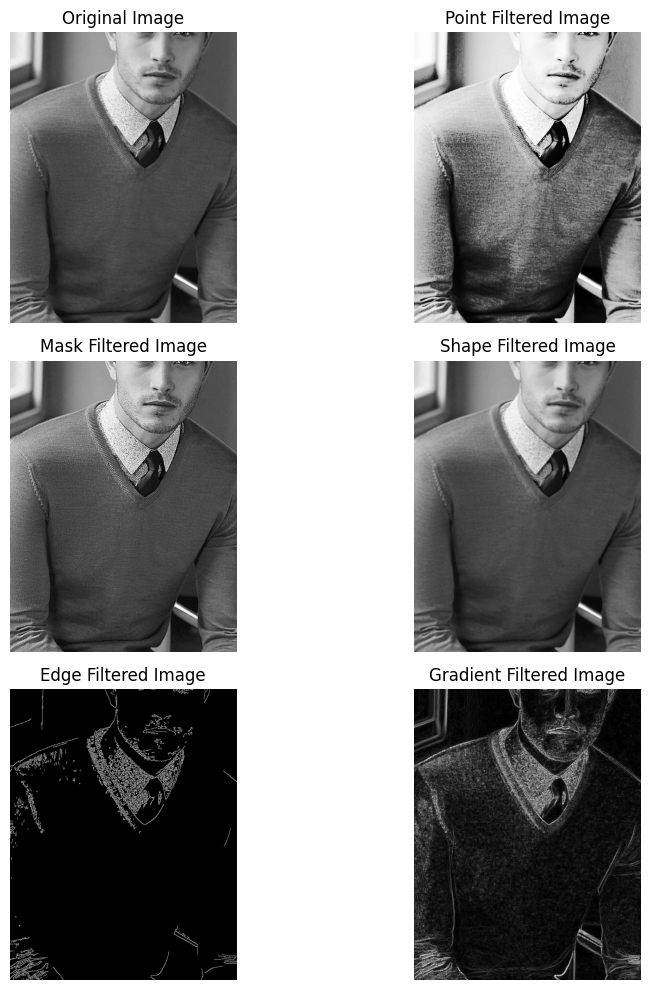

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image, technique):
    if technique == "point":
        # Apply point preprocessing technique
        filtered_image = cv2.equalizeHist(image)
    elif technique == "mask":
        # Apply mask preprocessing technique
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=np.float32)
        filtered_image = cv2.filter2D(image, -1, kernel)
    elif technique == "shape":
        # Apply shape preprocessing technique (blur)
        filtered_image = cv2.GaussianBlur(image, (5, 5), 0)
    elif technique == "edge":
        # Apply edge preprocessing technique
        filtered_image = cv2.Canny(image, 100, 200)
    elif technique == "gradient":
        # Apply gradient preprocessing technique (Sobel)
        gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        filtered_image = np.uint8(gradient_magnitude)
    else:
        raise ValueError("Invalid preprocessing technique provided")

    return filtered_image

# Load image
image = cv2.imread("crop.jpg", cv2.IMREAD_GRAYSCALE)

# List of preprocessing techniques
techniques = ["point", "mask", "shape", "edge", "gradient"]

# Create subplot
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Apply and display each preprocessing technique
for i, technique in enumerate(techniques):
    filtered_image = preprocess_image(image, technique)
    plt.subplot(3, 2, i+2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(technique.capitalize() + ' Filtered Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 7132 output values where the mask is true

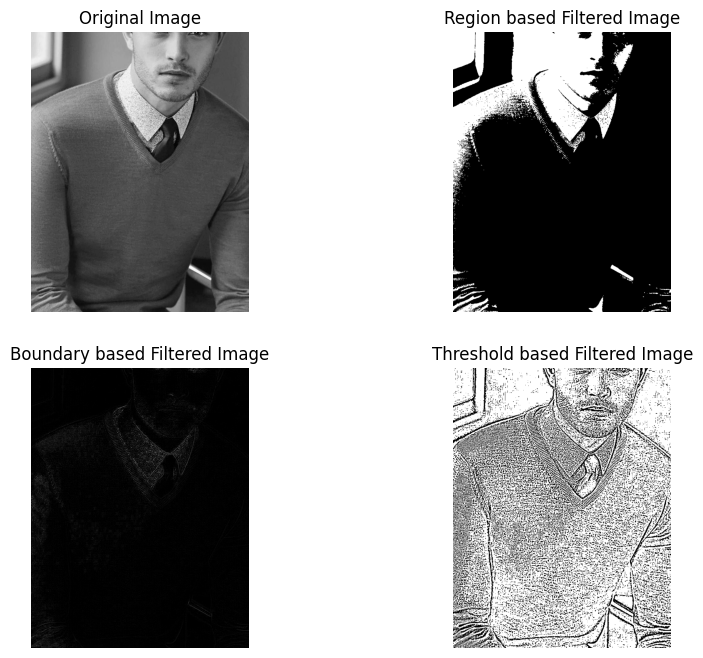

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image, technique):
    if technique == "region_based":
        # Apply region-based preprocessing technique (Segmentation)
        # Example: Simple thresholding
        _, filtered_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    elif technique == "boundary_based":
        # Apply boundary-based preprocessing technique
        # Example: Laplacian edge detection
        filtered_image = cv2.Laplacian(image, cv2.CV_8U)
    elif technique == "threshold_based":
        # Apply threshold-based preprocessing technique
        # Example: Adaptive thresholding
        filtered_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    elif technique == "watershed":
        # Apply watershed preprocessing technique
        # Example: Watershed segmentation
        _, filtered_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # Morphological operations to clean up image
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(filtered_image, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        _, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0
        filtered_image = cv2.watershed(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), markers)
        filtered_image[markers == -1] = [255, 0, 0]  # Mark watershed boundaries
    else:
        raise ValueError("Invalid preprocessing technique provided")

    return filtered_image

# Load image
image = cv2.imread("crop.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

# List of preprocessing techniques
techniques = ["region_based", "boundary_based", "threshold_based", "watershed"]

# Create subplot
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
if image.dtype != np.uint8:
    image = np.uint8(image)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Apply and display each preprocessing technique
for i, technique in enumerate(techniques):
    filtered_image = preprocess_image(image, technique)
    plt.subplot(2, 2, i+2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(technique.replace("_", " ").capitalize() + ' Filtered Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


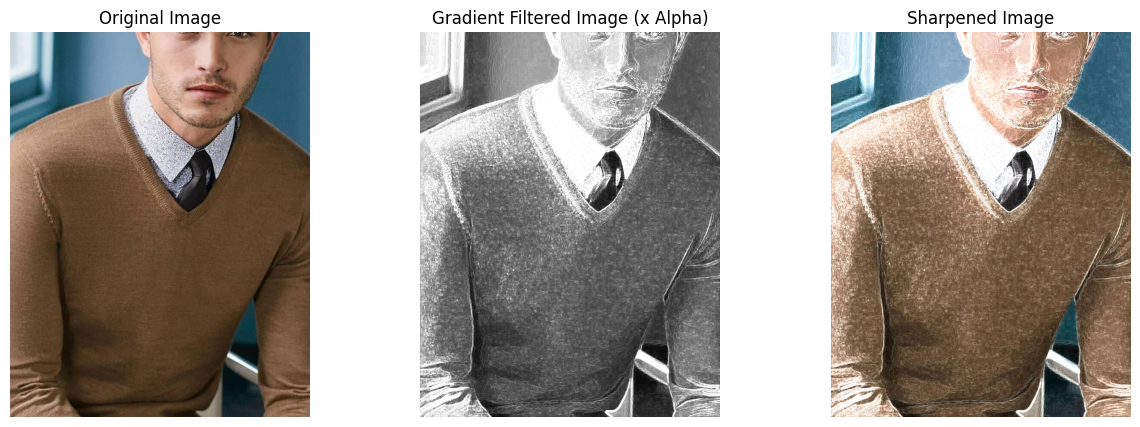

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sharpen_with_gradient(image, alpha=1.5):
    # Convert the RGB image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a gradient filter (Sobel) to the grayscale image
    gradient_x = cv2.Sobel(grayscale_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(grayscale_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Multiply the gradient filtered image by the parameter
    sharpened_image = alpha * gradient_magnitude
    
    # Convert back to uint8 and clip values greater than 255
    sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)
    
    # Add the sharpened image to the original RGB image
    sharpened_rgb = cv2.addWeighted(image, 1, cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2BGR), 1, 0)
    
    return sharpened_rgb

# Load the RGB image
image = cv2.imread("crop.jpg")

# Set alpha value for sharpening
alpha = 1.5

# Apply sharpening with gradient filter and add to original image
sharpened_image = sharpen_with_gradient(image, alpha=alpha)

# Create a 1x3 subplot
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Gradient filtered image multiplied by alpha
plt.subplot(1, 3, 2)
gradient_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gradient_image, cmap='gray')
plt.title("Gradient Filtered Image (x Alpha)")
plt.axis('off')

# Added image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.title("Sharpened Image")
plt.axis('off')

plt.show()


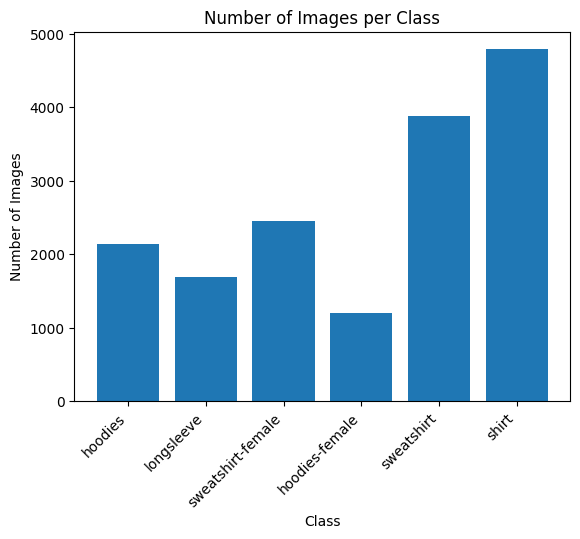

In [3]:
import os
import matplotlib.pyplot as plt

def get_image_stats(directory):
    class_stats = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            class_name = os.path.basename(root)
            if class_name not in class_stats:
                class_stats[class_name] = 0
            class_stats[class_name] += 1

    class_names = list(class_stats.keys())
    num_images = list(class_stats.values())

    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45, ha='right')
    plt.show()


directory = "/Users/shreyas/Desktop/6th_sem/CV_Lab/CV_Project/cv-cbir-optimization/data/zalando"
get_image_stats(directory)

In [4]:
import os
import random
import shutil

def sample_images(directory, sample_size=300, output_directory="/Users/shreyas/Desktop/6th_sem/CV_Lab/CV_Project/cv-cbir-optimization/data/sampled_data"):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for root, dirs, files in os.walk(directory):
        class_name = os.path.basename(root)
        output_class_directory = os.path.join(output_directory, class_name)
        if not os.path.exists(output_class_directory):
            os.makedirs(output_class_directory)

        images_to_sample = min(sample_size, len(files))
        sampled_images = random.sample(files, images_to_sample)

        for image_file in sampled_images:
            source_path = os.path.join(root, image_file)
            destination_path = os.path.join(output_class_directory, image_file)
            shutil.copyfile(source_path, destination_path)

# Example usage:
directory = "/Users/shreyas/Desktop/6th_sem/CV_Lab/CV_Project/cv-cbir-optimization/data/zalando"
sample_images(directory)

In [10]:
import os
from PIL import Image

def crop_and_resize_images(source_dir, target_dir, classes, crop_width, crop_height, resize_width, resize_height):
    for class_name in classes:
        source_class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)

        # Create the target class directory if it doesn't exist
        if not os.path.exists(target_class_dir):
            os.makedirs(target_class_dir)

        # Get the list of image files in the source class directory
        image_files = [f for f in os.listdir(source_class_dir) if f.endswith('.jpg') or f.endswith('.png')]

        for image_file in image_files:
            # Open the image
            image_path = os.path.join(source_class_dir, image_file)
            image = Image.open(image_path)

            # Get the dimensions of the image
            width, height = image.size

            # Calculate the coordinates for cropping
            left = (width - crop_width) // 2
            top = (height - crop_height) // 2
            right = left + crop_width
            bottom = top + crop_height

            # Crop the image
            cropped_image = image.crop((left, top, right, bottom))

            # Resize the cropped image
            resized_image = cropped_image.resize((resize_width, resize_height))

            # Save the resized image to the target directory
            resized_image_path = os.path.join(target_class_dir, image_file)
            resized_image.save(resized_image_path)

            # Close the image
            image.close()

# Example usage
source_directory = "/Users/shreyas/Desktop/6th_sem/CV_Lab/CV_Project/cv-cbir-optimization/data/sampled_data"
target_directory = "/Users/shreyas/Desktop/6th_sem/CV_Lab/CV_Project/cv-cbir-optimization/data/cropped"
classes = ["hoodies", "hoodies-female", "longsleeve", "shirt", "sweatshirt", "sweatshirt-female"]
crop_width = 500
crop_height = 500
resize_width = 256
resize_height = 256

crop_and_resize_images(source_directory, target_directory, classes, crop_width, crop_height, resize_width, resize_height)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


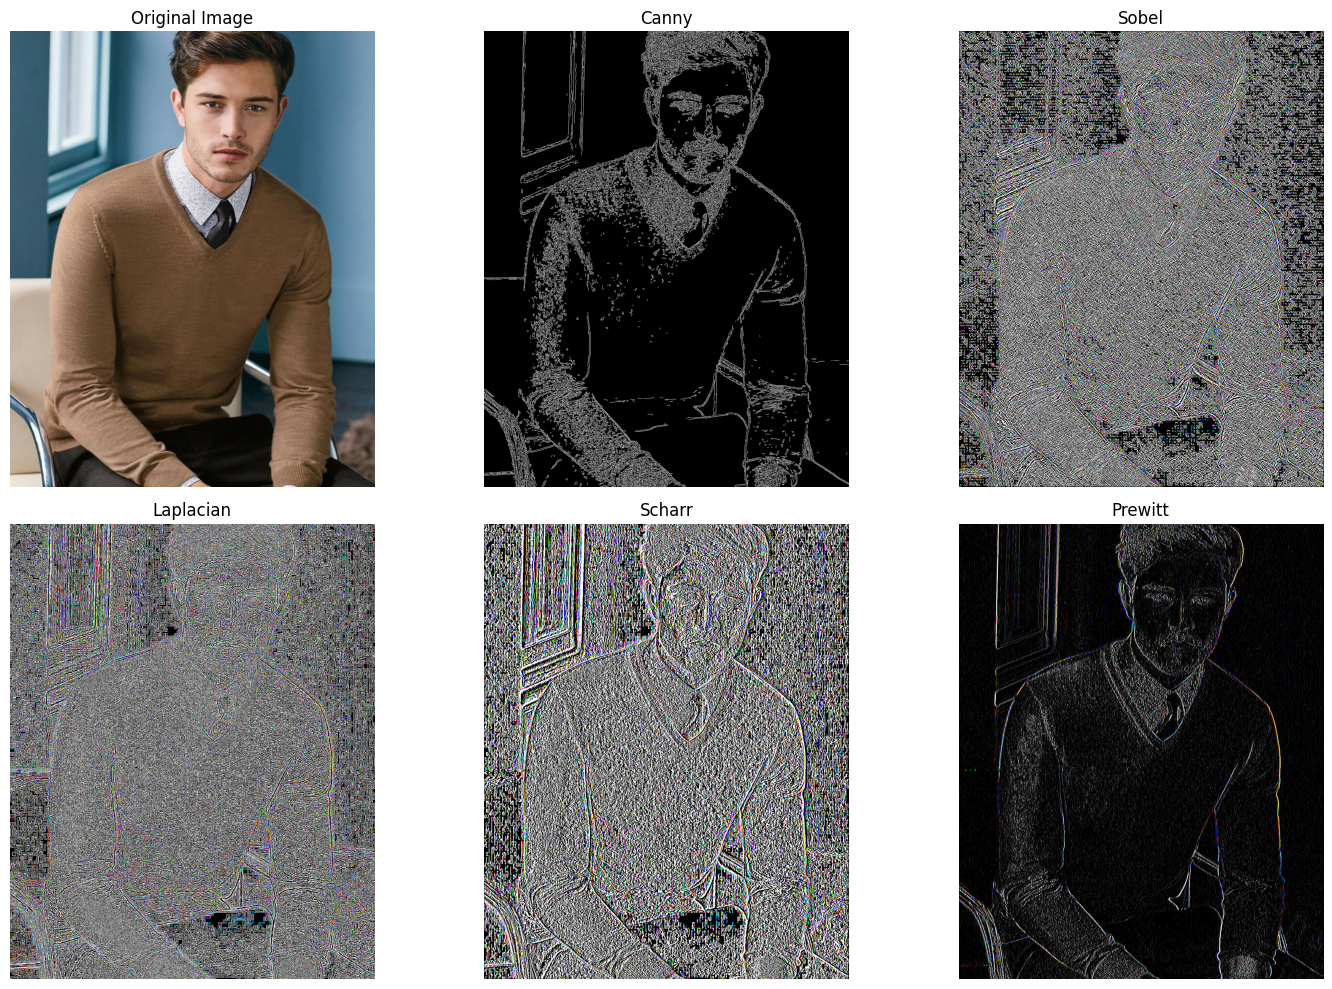

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detection_comparison(image):
    # Gradient sharpening
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sharpened_image = np.uint8(gradient_magnitude)
    
    # Apply different edge detection filters with increased thresholds
    filters = [
        ("Canny", cv2.Canny(sharpened_image, 150, 250)),
        ("Sobel", cv2.Sobel(sharpened_image, cv2.CV_64F, 1, 1, ksize=3)),
        ("Laplacian", cv2.Laplacian(sharpened_image, cv2.CV_64F)),
        ("Scharr", cv2.Scharr(sharpened_image, cv2.CV_64F, 1, 0)),
        ("Prewitt", cv2.filter2D(sharpened_image, -1, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))),
    ]
    
    # Plot the results in a 2x3 subplot layout
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the 2D array for easy indexing
    
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    for i, (name, filtered) in enumerate(filters, start=1):
        axes[i].imshow(filtered, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('sample.jpg')  # Load your image here
edge_detection_comparison(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


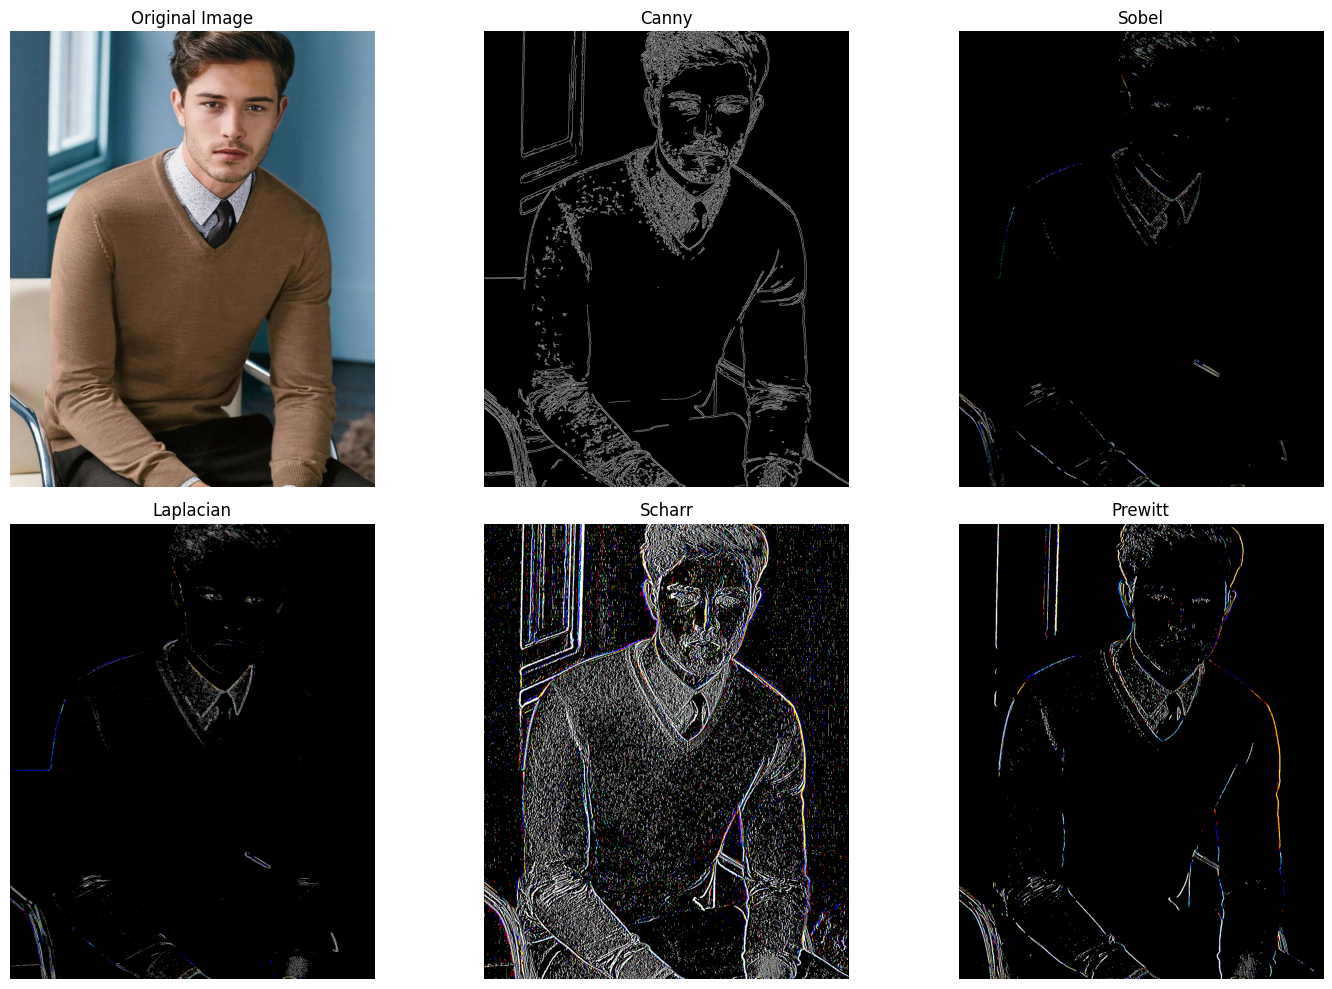

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detection_comparison(image):
    # Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Gradient sharpening
    gradient_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sharpened_image = np.uint8(gradient_magnitude)
    
    # Apply different edge detection filters with increased thresholds
    filters = [
        ("Canny", cv2.Canny(sharpened_image, 100, 200)),
        ("Sobel", cv2.Sobel(sharpened_image, cv2.CV_64F, 1, 1, ksize=3)),
        ("Laplacian", cv2.Laplacian(sharpened_image, cv2.CV_64F)),
        ("Scharr", cv2.Scharr(sharpened_image, cv2.CV_64F, 1, 0)),
        ("Prewitt", cv2.filter2D(sharpened_image, -1, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))),
    ]
    
    # Plot the results in a 2x3 subplot layout
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the 2D array for easy indexing
    
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    for i, (name, filtered) in enumerate(filters, start=1):
        # Apply thresholding to remove patches
        _, binary = cv2.threshold(filtered, 100, 255, cv2.THRESH_BINARY)
        axes[i].imshow(binary, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('sample.jpg')  # Load your image here
edge_detection_comparison(image)


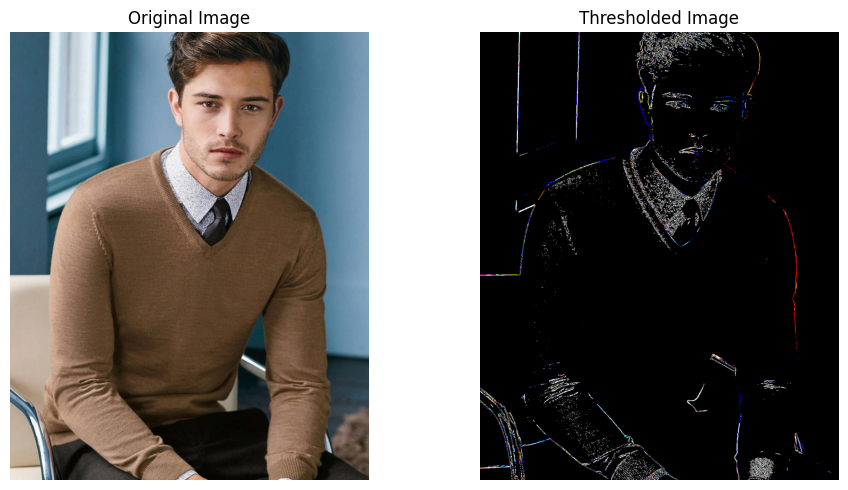

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detection_comparison(image):
    # Gradient sharpening
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sharpened_image = np.uint8(gradient_magnitude)
    
    # Apply thresholding to sharpened image
    _, thresholded = cv2.threshold(sharpened_image, 150, 255, cv2.THRESH_BINARY)
    
    # Display the original and thresholded images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(thresholded, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('sample.jpg')  # Load your image here
edge_detection_comparison(image)

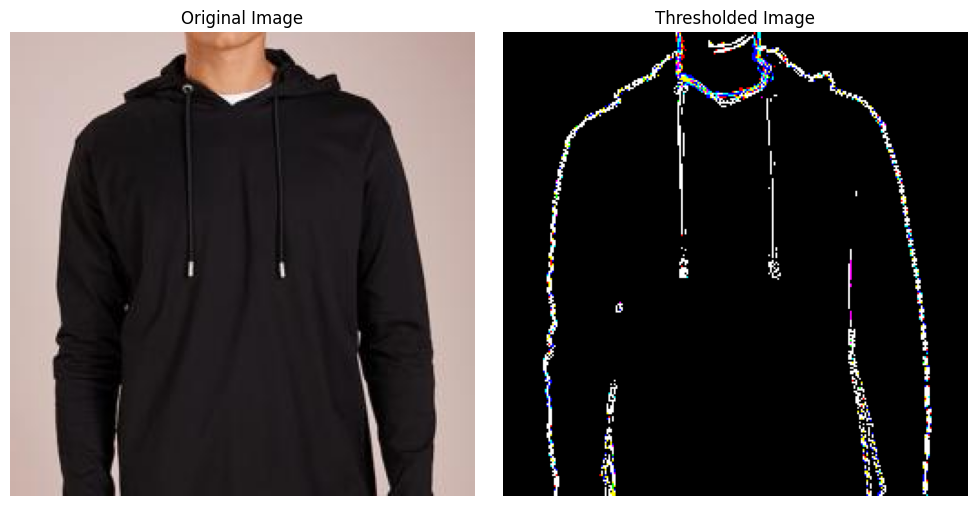

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detection_comparison(image):
    # Gradient sharpening
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sharpened_image = np.uint8(gradient_magnitude)
    
    # Apply thresholding to sharpened image
    _, thresholded = cv2.threshold(sharpened_image, 100, 255, cv2.THRESH_BINARY)
    
    # Display the original and thresholded images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(thresholded, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('sample2.jpg')  # Load your image here
edge_detection_comparison(image)

IndexError: index 2 is out of bounds for axis 0 with size 2

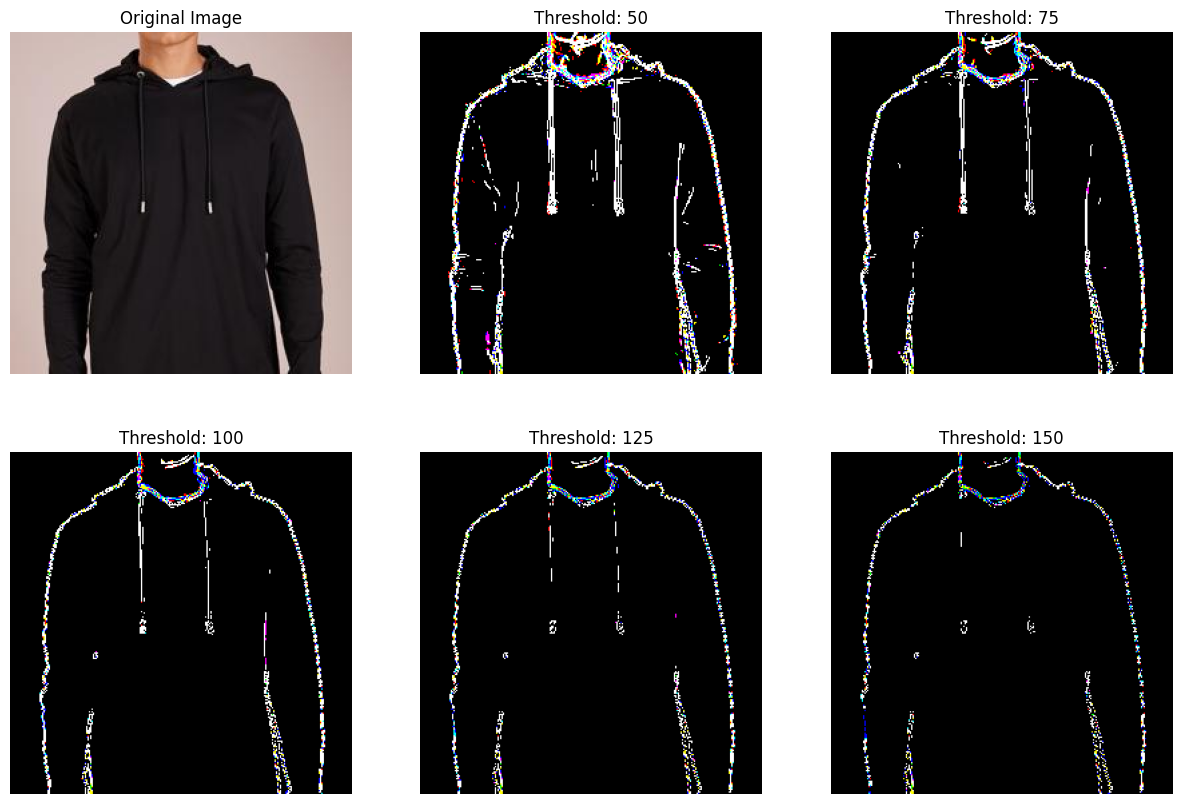

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detection_comparison(image, threshold):
    # Gradient sharpening
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sharpened_image = np.uint8(gradient_magnitude)
    
    # Apply thresholding to sharpened image
    _, thresholded = cv2.threshold(sharpened_image, threshold, 255, cv2.THRESH_BINARY)
    
    return thresholded

# Example usage and plot for multiple threshold values
image = cv2.imread('sample2.jpg')  # Load your image here
threshold_values = [50, 75, 100, 125, 150, 175]

num_thresholds = len(threshold_values)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Plot thresholded images
for i, threshold in enumerate(threshold_values, start=1):
    thresholded_image = edge_detection_comparison(image, threshold)
    axes[i // 3, i % 3].imshow(thresholded_image, cmap='gray')
    axes[i // 3, i % 3].set_title(f'Threshold: {threshold}')
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import shutil

# Define input directory
input_dir = "/kaggle/input/zalando-store-crawl/zalando"
# Define output directory
output_dir = "/kaggle/working//preprocessed_images"

# Define classes
classes = ["hoodies", "hoodies-female", "longsleeve", "shirt", "sweatshirt", "sweatshirt-female"]

# Create output directories for each class
for class_name in classes:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Function to preprocess an image
def preprocess_image(image):
    # Resize image to 224x224 pixels
    resized_image = cv2.resize(image, (224, 224))

    # Normalize pixel values to range [0, 1]
    normalized_image = resized_image.astype(np.float32) / 255.0

    # Enhance details
    sharpened_image = cv2.filter2D(resized_image, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))  # Sharpening

    return resized_image, normalized_image, sharpened_image

# Loop through each class and preprocess 300 images in each class
for class_name in classes:
    class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)

    # Get list of image files for the current class
    image_files = [filename for filename in os.listdir(class_dir) if filename.endswith(('.png', '.jpg', '.jpeg'))]

    # Process 300 images in the current class
    for filename in image_files[:300]:
        # Read original image
        img_path = os.path.join(class_dir, filename)
        original_image = cv2.imread(img_path)

        # Preprocess image
        _, _, sharpened_image = preprocess_image(original_image)
        cropped_image = sharpened_image[40:, :]

        # Save preprocessed image
        output_img_path = os.path.join(output_class_dir, filename)
        cv2.imwrite(output_img_path, cropped_image)

        print(f"Preprocessed image saved: {output_img_path}")